start date in format yyyy-mm-dd: 2022-08-15
end date in format yyyy-mm-dd: 2023-08-15
ticker: spy


[*********************100%***********************]  1 of 1 completed


slicing: 1


C:\Users\super\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


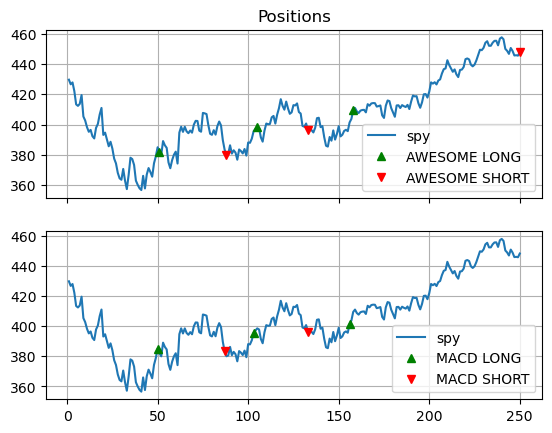

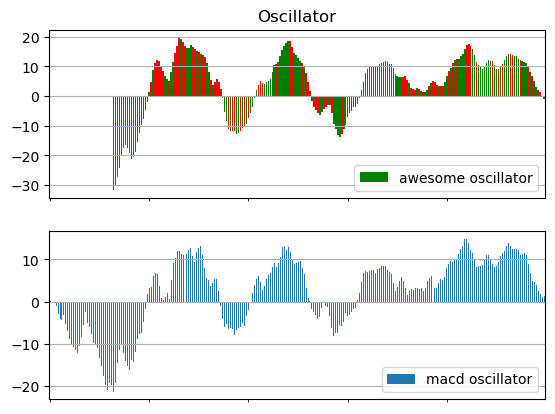

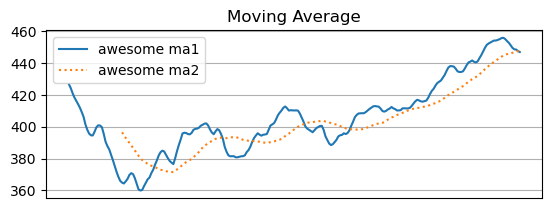

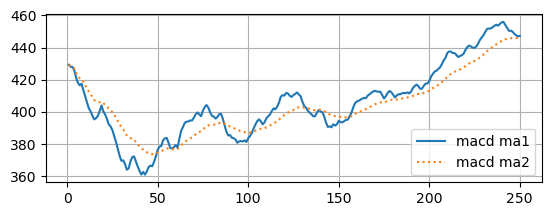

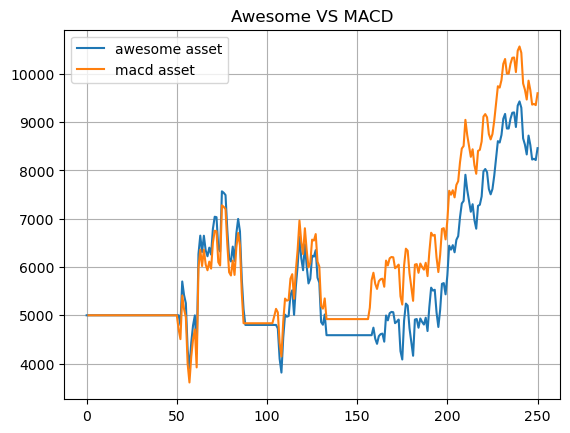

KeyError: 1

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf  # Using yfinance instead of fix_yahoo_finance


# In[2]:

#this part is macd
#i will not go into details as i have another session called macd
#the only difference is that i use ewma function to apply exponential smoothing technique
def ewmacd(signals,ma1,ma2):
    
    signals['macd ma1']=signals['Close'].ewm(span=ma1).mean()    
    signals['macd ma2']=signals['Close'].ewm(span=ma2).mean()   
    
    return signals
    
def signal_generation(df,method,ma1,ma2):
    
    signals=method(df,ma1,ma2)
    signals['macd positions']=0
    signals['macd positions'][ma1:]=np.where(signals['macd ma1'][ma1:]>=signals['macd ma2'][ma1:],1,0)
    signals['macd signals']=signals['macd positions'].diff()
    signals['macd oscillator']=signals['macd ma1']-signals['macd ma2']
    
    return signals


# In[3]:
    
#for awesome oscillator
#moving average is based on the mean of high and low instead of close price
def awesome_ma(signals):
    
    signals['awesome ma1'],signals['awesome ma2']=0,0
    signals['awesome ma1']=((signals['High']+signals['Low'])/2).rolling(window=5).mean()
    signals['awesome ma2']=((signals['High']+signals['Low'])/2).rolling(window=34).mean()
    
    return signals


#awesome signal generation,AWESOME!
def awesome_signal_generation(df,method):
    
    signals=method(df)
    signals.reset_index(inplace=True)
    signals['awesome signals']=0
    signals['awesome oscillator']=signals['awesome ma1']-signals['awesome ma2']  
    signals['cumsum']=0


    for i in range(2,len(signals)):

        #awesome oscillator has an extra way to generate signals
        #its called saucer
        #A Bearish Saucer setup occurs when the AO is below the Zero Line
        #in another word, awesome oscillator is negative
        #A Bearish Saucer entails two consecutive green bars (with the second bar being higher than the first bar) being followed by a red bar.
        #in another word, green bar refers to open price is higher than close price
    
        if (signals['Open'][i]>signals['Close'][i] and 
        signals['Open'][i-1]<signals['Close'][i-1] and 
        signals['Open'][i-2]<signals['Close'][i-2] and
        signals['awesome oscillator'][i-1]>signals['awesome oscillator'][i-2] and
        signals['awesome oscillator'][i-1]<0 and 
        signals['awesome oscillator'][i]<0):
            signals.at[i,'awesome signals']=1


        #this is bullish saucer
        #vice versa
        
        if (signals['Open'][i]<signals['Close'][i] and 
        signals['Open'][i-1]>signals['Close'][i-1] and 
        signals['Open'][i-2]>signals['Close'][i-2] and
        signals['awesome oscillator'][i-1]<signals['awesome oscillator'][i-2] and
        signals['awesome oscillator'][i-1]>0 and
        signals['awesome oscillator'][i]>0):
            signals.at[i,'awesome signals']=-1


        #this part is the same as macd signal generation
        #nevertheless, we have extra rules to get signals ahead of moving average
        #if we get signals before moving average generate any signal
        #we will ignore signals generated by moving average then
        #as it is delayed and probably deliver fewer profit than previous signals
        #we use cumulated sum to see if there has been created any open positions
        #if so, we will take a pass
        
        if signals['awesome ma1'][i]>signals['awesome ma2'][i]:
            signals.at[i,'awesome signals']=1
            signals['cumsum']=signals['awesome signals'].cumsum()
            if signals['cumsum'][i]>1:
                signals.at[i,'awesome signals']=0
            
        if signals['awesome ma1'][i]<signals['awesome ma2'][i]:
            signals.at[i,'awesome signals']=-1
            signals['cumsum']=signals['awesome signals'].cumsum()
            if signals['cumsum'][i]<0:
                signals.at[i,'awesome signals']=0
    
    signals['cumsum']=signals['awesome signals'].cumsum()
    
    return signals


# In[4]:
    
#we plot the results to compare
#basically the same as macd
#im not gonna explain much
def plot(new,ticker):
    
    #positions
    fig=plt.figure()
    ax=fig.add_subplot(211)

    new['Close'].plot(label=ticker)
    ax.plot(new.loc[new['awesome signals']==1].index,new['Close'][new['awesome signals']==1],label='AWESOME LONG',lw=0,marker='^',c='g')
    ax.plot(new.loc[new['awesome signals']==-1].index,new['Close'][new['awesome signals']==-1],label='AWESOME SHORT',lw=0,marker='v',c='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')

    bx=fig.add_subplot(212,sharex=ax)
    new['Close'].plot(label=ticker)
    bx.plot(new.loc[new['macd signals']==1].index,new['Close'][new['macd signals']==1],label='MACD LONG',lw=0,marker='^',c='g')
    bx.plot(new.loc[new['macd signals']==-1].index,new['Close'][new['macd signals']==-1],label='MACD SHORT',lw=0,marker='v',c='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    
    #oscillator
    fig=plt.figure()
    cx=fig.add_subplot(211)

    c=np.where(new['Open']>new['Close'],'r','g')
    cx.bar(range(len(new)),new['awesome oscillator'],color=c,label='awesome oscillator')

    plt.grid(True)
    plt.legend(loc='best')
    plt.title('Oscillator')

    dx=fig.add_subplot(212,sharex=cx)

    new['macd oscillator'].plot(kind='bar',label='macd oscillator')

    plt.grid(True)
    plt.legend(loc='best')
    plt.xlabel('')
    plt.xticks([])
    plt.show()



    #moving average
    fig=plt.figure()
    ex=fig.add_subplot(211)

    new['awesome ma1'].plot(label='awesome ma1')
    new['awesome ma2'].plot(label='awesome ma2',linestyle=':')

    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks([])
    plt.xlabel('')
    plt.title('Moving Average')

    fig=plt.figure()
    fx=fig.add_subplot(212,sharex=bx)
    
    new['macd ma1'].plot(label='macd ma1')
    new['macd ma2'].plot(label='macd ma2',linestyle=':')

    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


# In[5]:
    
#normally i dont include backtesting stats
#for the comparison, i am willing to make an exception
#capital0 is intial capital
#positions defines how much shares we buy for every single trade
def portfolio(signals):
        
    capital0=5000
    positions=100

    portfolio=pd.DataFrame()
    portfolio['Close']=signals['Close']
    
    #cumsum is used to calculate the change of value while holding shares
    portfolio['awesome holding']=signals['cumsum']*portfolio['Close']*positions
    portfolio['macd holding']=signals['macd positions']*portfolio['Close']*positions

    #basically cash is initial capital minus the profit we make from every trade
    #note that we have to use cumulated sum to add every profit into our cash
    portfolio['awesome cash']=capital0-(signals['awesome signals']*portfolio['Close']*positions).cumsum()
    portfolio['macd cash']=capital0-(signals['macd signals']*portfolio['Close']*positions).cumsum()

    portfolio['awesome asset']=portfolio['awesome holding']+portfolio['awesome cash']
    portfolio['macd asset']=portfolio['macd holding']+portfolio['macd cash']

    portfolio['awesome return']=portfolio['awesome asset'].pct_change()
    portfolio['macd return']=portfolio['macd asset'].pct_change()
    
    return portfolio


# In[6]:

#lets plot how two strategies increase our asset value
def profit(portfolio):
        
    gx=plt.figure()
    gx.add_subplot(111)

    portfolio['awesome asset'].plot()
    portfolio['macd asset'].plot()

    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Awesome VS MACD')
    plt.show()


# In[7]:

#i use a function to calculate maximum drawdown
#the idea is simple
#for every day, we take the current asset value
#to compare with the previous highest asset value
#we get our daily drawdown
#it is supposed to be negative if it is not the maximum for this period so far
#we implement a temporary variable to store the minimum value
#which is called maximum drawdown
#for each daily drawdown that is smaller than our temporary value
#we update the temp until we finish our traversal
#in the end we return the maximum drawdown
def mdd(series):

    temp=0
    for i in range(1,len(series)):
        if temp>(series[i]/max(series[:i])-1):
            temp=(series[i]/max(series[:i])-1)

    return temp
def stats(portfolio):
    portfolio = portfolio.dropna()  # Drop NaN values from portfolio DataFrame

    stats = pd.DataFrame()  # Create an empty DataFrame without a single value

    stats['awesome sharpe'] = (portfolio['awesome asset'].iloc[-1] / 5000 - 1) / np.std(portfolio['awesome return'])
    stats['macd sharpe'] = (portfolio['macd asset'].iloc[-1] / 5000 - 1) / np.std(portfolio['macd return'])

    stats['awesome mdd'] = mdd(portfolio['awesome asset'])
    stats['macd mdd'] = mdd(portfolio['macd asset'])

    print(stats)

# In[8]:   

def main():
    
    #awesome oscillator uses 5 lags as short ma
    #34 lags as long ma
    #for the consistent comparison
    #i apply the same to macd oscillator
    ma1=5
    ma2=34

    #downloading
    stdate=input('start date in format yyyy-mm-dd:')
    eddate=input('end date in format yyyy-mm-dd:')
    ticker=input('ticker:')
    df=yf.download(ticker,start=stdate,end=eddate)

    #slicing the downloaded dataset
    #if the dataset is too large
    #backtesting plot would look messy
    slicer=int(input('slicing:'))
    signals=signal_generation(df,ewmacd,ma1,ma2)
    sig=awesome_signal_generation(signals,awesome_ma)
    new=sig[slicer:]
    plot(new,ticker)
    
    portfo=portfolio(sig)
    profit(portfo)
    
    stats(portfo)
    
    #from my tests
    #macd has demonstrated a higher sharpe ratio
    #it executes fewer trades but brings more profits
    #however its maximum drawdown is higher than awesome oscillator
    #which one is better?
    #it depends on your risk averse level


if __name__ == '__main__':
    main()
